# Introduction 

My Kaggle attempt to classify cats and dogs. This notebook can be run directly in Kaggle platform by importing it there.

Some Updates compared to off-line version:
- Full data has been used to train model
- Data Augmentation
- Prediction function
- Larger model

# Imports

In [31]:
import numpy as np 
import pandas as pd 
import os

import random
import shutil

import zipfile

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
print(f"TF version is: {tf.__version__}")

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

TF version is: 2.6.4


In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [9]:
local_zip = '/kaggle/input/dogs-vs-cats/train.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/')
zip_ref.close()

In [10]:
train_path = '/train'
f_names = os.listdir(train_path)
print(f"count of data points: {len(f_names)}")

count of data points: 25000


Split data to train and validation sets:

In [11]:
random.seed(1)
split_ratio = 0.8
sample_data = random.sample(f_names, len(f_names))
train_sample  = sample_data[:int(split_ratio * len(f_names))]
validation_sample = sample_data[int(split_ratio * len(f_names)):]


Create sub directories for train and validation classes and copy files into correct directories:

In [13]:
# Directory with training cat/dog pictures
train_cats_dir = '/train/cat'
train_dogs_dir = '/train/dog'

# Directory with validation cat/dog pictures
validation_cats_dir = '/validation/cat'
validation_dogs_dir = '/validation/dog'

# create directories:
os.makedirs(train_dogs_dir,exist_ok = True)
os.makedirs(train_cats_dir,exist_ok = True)
os.makedirs(validation_dogs_dir,exist_ok = True)
os.makedirs(validation_cats_dir,exist_ok = True)

# copy the data:
# train data:
for v in train_sample:
    if 'cat' in v.lower():
        shutil.copy('/train/'+ v,'/train/cat/'+ v)
    else:
         shutil.copy('/train/' + v,'/train/dog/' + v)

# validation data:
for v in validation_sample:
    if 'cat' in v.lower():
        shutil.copy('/train/'+ v,'/validation/cat/'+ v)
    else:
        shutil.copy('/train/'+ v,'/validation/dog/'+ v)

print(f'count of cats in training: {len(os.listdir(train_cats_dir))}')
print(f'count of dogs in training: {len(os.listdir(train_dogs_dir))}')

count of cats in training: 10013
count of dogs in training: 9987


## Baseline model

### Data pre-processing

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory('/train',
                                                    batch_size=50,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory('/validation',
                                                         batch_size=50,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


### Create the Model

In [21]:
def create_model():
    '''Creates a CNN with 4 convolutional layers'''
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])

    return model

In [22]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [23]:
history = model.fit(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
            verbose=1
            )

Epoch 1/15
400/400 [==============================] - 384s 957ms/step - loss: 0.6176 - accuracy: 0.6448 - val_loss: 0.5405 - val_accuracy: 0.7144
Epoch 2/15
400/400 [==============================] - 385s 961ms/step - loss: 0.5155 - accuracy: 0.7443 - val_loss: 0.4722 - val_accuracy: 0.7676
Epoch 3/15
400/400 [==============================] - 384s 959ms/step - loss: 0.4639 - accuracy: 0.7814 - val_loss: 0.5086 - val_accuracy: 0.7416
Epoch 4/15
400/400 [==============================] - 382s 954ms/step - loss: 0.4258 - accuracy: 0.8009 - val_loss: 0.3941 - val_accuracy: 0.8238
Epoch 5/15
400/400 [==============================] - 384s 959ms/step - loss: 0.3931 - accuracy: 0.8234 - val_loss: 0.3914 - val_accuracy: 0.8218
Epoch 6/15
400/400 [==============================] - 383s 956ms/step - loss: 0.3657 - accuracy: 0.8368 - val_loss: 0.3831 - val_accuracy: 0.8272
Epoch 7/15
400/400 [==============================] - 387s 967ms/step - loss: 0.3407 - accuracy: 0.8525 - val_loss: 0.3477 -

In [26]:
import matplotlib.pyplot as plt
# function for plotting the accuracy and loss vs epochs
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

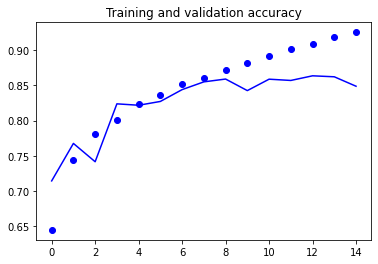

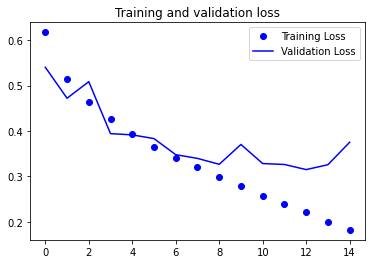

In [27]:
# Plot training results
plot_loss_acc(history)

### Predicting the test data:

In [32]:
def model_predict(model, data_path):
    f_names = os.listdir(data_path)
    labels =[]
    ids=[]
    for v in tqdm(f_names):    
        img=load_img('/test1/' + v, target_size=(150, 150))
        x = img_to_array(img)
        x = x /255
        x=np.expand_dims(x, axis=0)
        images = np.vstack([x])

        ids.append(int(v.rsplit( ".", 1 )[ 0 ]))

        if model.predict(images, batch_size=10) > 0.5:
            labels.append(1)
        else:
            labels.append(0)
    return ids, labels

In [33]:
local_zip = '/kaggle/input/dogs-vs-cats/test1.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/')
zip_ref.close()

In [34]:
df_sub = pd.DataFrame({'id':[],'label':[]})
ids, labels = model_predict(model, '/test1/')
df_sub['id']=ids
df_sub['label']= labels
print(df_sub.shape)
df_sub.head()
# save the dataframe:
sub_name = 'cat_dog_predictions_simple_cnn.csv'
df_sub.to_csv('/kaggle/working/'+sub_name)

100%|██████████| 12500/12500 [13:51<00:00, 15.04it/s]

(12500, 2)


## Data Augmentation

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/10
100/100 - 53s - loss: 0.6869 - accuracy: 0.5380 - val_loss: 0.6883 - val_accuracy: 0.5040
Epoch 2/10
100/100 - 51s - loss: 0.6771 - accuracy: 0.5635 - val_loss: 0.6367 - val_accuracy: 0.6430
Epoch 3/10
100/100 - 52s - loss: 0.6643 - accuracy: 0.5860 - val_loss: 0.6328 - val_accuracy: 0.6490
Epoch 4/10
100/100 - 52s - loss: 0.6429 - accuracy: 0.6295 - val_loss: 0.5972 - val_accuracy: 0.6740
Epoch 5/10
100/100 - 51s - loss: 0.6405 - accuracy: 0.6275 - val_loss: 0.5809 - val_accuracy: 0.6910
Epoch 6/10
100/100 - 52s - loss: 0.6348 - accuracy: 0.6375 - val_loss: 0.5738 - val_accuracy: 0.7140
Epoch 7/10
100/100 - 55s - loss: 0.6158 - accuracy: 0.6585 - val_loss: 0.5503 - val_accuracy: 0.7030
Epoch 8/10
100/100 - 52s - loss: 0.6168 - accuracy: 0.6660 - val_loss: 0.5779 - val_accuracy: 0.6820
Epoch 9/10
100/100 - 52s - loss: 0.5966 - accuracy: 0.6770 - val_loss: 0.5473 - val_accuracy: 0.7200
Epoch 

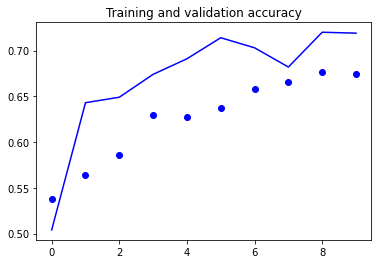

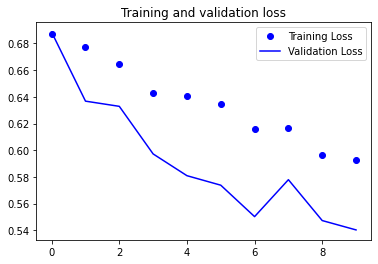

In [37]:
# Create new model
model_for_aug = create_model()

# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/train',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        '/validation',
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

# Train the new model
history_with_aug = model_for_aug.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

plot_loss_acc(history_with_aug)

In [38]:
df_sub_aug = pd.DataFrame({'id':[],'label':[]})
ids, labels = model_predict(model_for_aug, '/test1/')
df_sub_aug['id']=ids
df_sub_aug['label']= labels
print(df_sub_aug.shape)
df_sub_aug.head()
# save the dataframe:
sub_name = 'cat_dog_predictions_cnn_augmentation.csv'
df_sub.to_csv('/kaggle/working/'+sub_name)

100%|██████████| 12500/12500 [14:12<00:00, 14.67it/s]

(12500, 2)
